In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

from pathlib import Path
import shutil
from tqdm import tqdm
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from utils import *
from IQA_metrics import table_of_score
from visualize_attributes import  EmbeddingDataset
from siamese import generate_train_test_set

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay, roc_auc_score, f1_score

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

In [2]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "data/multi_classed_grouped_data")
products = os.listdir(data_path)

In [3]:
# Find optimal embedding through the embeddings of good samples
generate_embeddings_dict = False
find_embeddings = True


# ResNet50 model to find embeddings 
model = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
# model.fc = nn.Linear(2048, 2)
modules=list(model.children())[:-1]
model=nn.Sequential(*modules)
for p in model.parameters():
    p.requires_grad = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Find model image by embedding for each product
if generate_embeddings_dict:
    for product in products:
        print("----------------------------" + product + "----------------------------")
        product_path = os.path.join(data_path, product)
        good_images_path = os.path.join(product_path, 'train')
        defect_images_path = os.path.join(product_path, 'test/defect')
        
        train_good_image_list, test_good_image_list, all_train_defect_image_list, all_test_defect_image_list = generate_train_test_set(product_path)
        train_dict = dict(zip(train_good_image_list + all_train_defect_image_list, [1]*len(train_good_image_list) + [0]*len(all_train_defect_image_list)))
        test_dict = dict(zip(test_good_image_list + all_test_defect_image_list, [1]*len(test_good_image_list) + [0]*len(all_test_defect_image_list)))

        # A set to calculate embeddings on:
        all_good_image_dict = dict(zip(train_good_image_list + test_good_image_list, [1]*len(train_good_image_list) + [1]*len(test_good_image_list)))
        embedding_dataset = EmbeddingDataset(all_good_image_dict)
        transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((1024,1024), antialias=True)
                                    ])
        dataset = EmbeddingDataset(all_good_image_dict, transform)
        dataloader = DataLoader(dataset, batch_size=12, shuffle=True)

        # Find embeddings of all good images
        embeddings_path = os.path.join(root_path, 'data/table_of_score_data/all_good_' + product + '.csv')
        if find_embeddings:
            all_good_embeddings = []
            for data,labels in tqdm(dataloader):
                new_labels = labels.numpy().tolist()
                data = data.to(device)
                embeddings = model(data)
                all_good_embeddings.append(np.reshape(embeddings.detach().cpu().numpy(),(len(new_labels),-1)))
            all_good_embeddings = np.vstack(all_good_embeddings)
            # Save embeddings to prevent rerunning
            np.savetxt(embeddings_path, all_good_embeddings, delimiter=",")
            print('Saved embeddings')
        else:
            all_good_embeddings = np.loadtxt(embeddings_path, delimiter=",")
        all_good_embeddings_dict = dict(zip(list(range(len(all_good_embeddings))), all_good_embeddings))

        # Loop through each image of each dictionary, find an optimal embedding/model image for each image
        i = 0
        for test_image_dict in [train_dict, test_dict]:
            model_image_list = []
            for image_path in tqdm(list(test_image_dict.keys())):
                image_dict = {image_path: test_image_dict[image_path]}
            
                embedding_dataset = EmbeddingDataset(image_dict, transform=transform)
                embedding_dataloader = DataLoader(embedding_dataset, batch_size=1, shuffle=True)
            
                # Check embedding:
                for data, _ in embedding_dataloader:
                    data = data.to(device)
                    embedding = model(data)
                embedding = embedding.squeeze().detach().cpu().numpy()

                # Check closest embedded data based on distance:
                top_embeddings = dict(sorted(all_good_embeddings_dict.items(), 
                                    key=lambda x: distance(embedding, x[1])))
                #print(list(top_embeddings.keys()))
                candidate_id_list = list(top_embeddings.keys())[0]
                candidate_path = list(all_good_image_dict.keys())[candidate_id_list]
                model_image_list.append(candidate_path)
            
            name = ['train', 'test'][i]
            # Settle on a model image list containing a model image path for each product
            model_image_list_path = os.path.join(root_path, 'data/table_of_score_data/model_image_list_' + product + '_' + name + '.txt')
            with open(model_image_list_path, 'w', encoding='utf-8') as file:
                file.writelines(f"{model_image_path}\n" for model_image_path in model_image_list)
            print(len(model_image_list), [len(train_dict.keys()), len(test_dict.keys())][i])
            print("Saved " + name + " model image path list")
            i += 1

        # Save train and test dict to later calculate table of scores
        train_dict_path = os.path.join(root_path, 'data/table_of_score_data/train_dict_' + product + '.json')
        with open(train_dict_path, 'w', encoding='utf-8') as file:
            # Write the dictionary to the file as JSON
            json.dump(train_dict, file, indent=4)
        print("Saved train dict")

        test_dict_path = os.path.join(root_path, 'data/table_of_score_data/test_dict_' + product + '.json')
        with open(test_dict_path, 'w', encoding='utf-8') as file:
            # Write the dictionary to the file as JSON
            json.dump(test_dict, file, indent=4)
        print("Saved test dict")


In [4]:
generate_table_of_score = False
if generate_table_of_score:
    for product in products:
        print(product)
        product_path = os.path.join(data_path, product)
        good_images_path = os.path.join(product_path, 'train')
        defect_images_path = os.path.join(product_path, 'test/defect')
        
        # Load train, test dict
        train_dict_path = os.path.join(root_path, 'data/table_of_score_data/train_dict_' + product + '.json')
        with open(train_dict_path, 'r', encoding='utf-8') as file:
            # Load and parse the JSON data into a Python dictionary
            train_dict = json.load(file)

        test_dict_path = os.path.join(root_path, 'data/table_of_score_data/test_dict_' + product + '.json')
        with open(test_dict_path, 'r', encoding='utf-8') as file:
            # Load and parse the JSON data into a Python dictionary
            test_dict = json.load(file)

        # Load saved model image data
        train_model_image_list_path = os.path.join(root_path, 'data/table_of_score_data/model_image_list_' + product + '_train.txt')
        train_model_image_list = []
        with open(train_model_image_list_path, 'r', encoding='utf-8') as file:
            train_model_image_list = file.readlines()
        train_model_image_list = [line.strip() for line in train_model_image_list]


        test_model_image_list_path = os.path.join(root_path, 'data/table_of_score_data/model_image_list_' + product + '_test.txt')
        test_model_image_list = []
        with open(test_model_image_list_path, 'r', encoding='utf-8') as file:
            test_model_image_list = file.readlines()
        test_model_image_list = [line.strip() for line in test_model_image_list]

        # Calculate table of score
        train_table_of_score = table_of_score(train_model_image_list, train_dict)
        test_table_of_score = table_of_score(test_model_image_list, test_dict)
        
        # Save tables of score
        np.savetxt(os.path.join(root_path, ('result/table_of_scores/' + product + '_train_table_of_score_2.csv')), train_table_of_score, delimiter=",")
        np.savetxt(os.path.join(root_path, ('result/table_of_scores/' + product + '_test_table_of_score_2.csv')), test_table_of_score, delimiter=",")

#### Combine and analyze tables of score

In [5]:
all_train_table_of_score = np.array([])
all_test_table_of_score = np.array([])
#shape_list_1 = []

for product in products:
    print(product)
    train_table_of_score_1 = np.loadtxt(os.path.join(root_path, ('result/table_of_scores/' + 
                                                                 product + '_train_table_of_score.csv')), delimiter=",", dtype=np.float64)
    train_table_of_score_2 = np.loadtxt(os.path.join(root_path, ('result/table_of_scores/' + 
                                                                 product + '_train_table_of_score_2.csv')), delimiter=",", dtype=np.float64)
    test_table_of_score_1 = np.loadtxt(os.path.join(root_path, ('result/table_of_scores/' + 
                                                                product + '_test_table_of_score.csv')), delimiter=",", dtype=np.float64)
    test_table_of_score_2 = np.loadtxt(os.path.join(root_path, ('result/table_of_scores/' + 
                                                                product + '_test_table_of_score_2.csv')), delimiter=",", dtype=np.float64)

    #print(train_table_of_score_1.shape, train_table_of_score_2.shape)
    train_table_of_score = np.hstack((train_table_of_score_1[:,:-1], train_table_of_score_2))
    
    #print(test_table_of_score_1.shape, test_table_of_score_2.shape)
    test_table_of_score = np.hstack((test_table_of_score_1[:,:-1], test_table_of_score_2))

    if len(all_train_table_of_score) == 0 or len(all_test_table_of_score) == 0:
        all_train_table_of_score = train_table_of_score
        all_test_table_of_score = test_table_of_score
    #shape_list_1.append(train_table_of_score.shape)
    
    all_train_table_of_score = np.concatenate((all_train_table_of_score, train_table_of_score))
    all_test_table_of_score = np.concatenate((all_test_table_of_score, test_table_of_score))

# 'issm' always return 0, so we just gonna remove it
all_train_table_of_score = pd.DataFrame(all_train_table_of_score, columns = ['psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre', 'class'])
all_test_table_of_score = pd.DataFrame(all_test_table_of_score, columns = ['psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre', 'class'])
all_train_table_of_score

bottle
cable
capsule
carpet
grid
hazelnut
leather
metal_nut
pill
screw
tile
toothbrush
transistor
wood
zipper


,psnr,fsim,ssim,uiq,sam,sre,class
0,48.022569,0.369187,0.984333,48.022569,0.369187,0.984333,1.0
1,48.623152,0.449128,0.988838,48.623152,0.449128,0.988838,1.0
2,49.787530,0.469760,0.990347,49.787530,0.469760,0.990347,1.0
3,48.125874,0.409598,0.986053,48.125874,0.409598,0.986053,1.0
4,48.476242,0.394021,0.987050,48.476242,0.394021,0.987050,1.0
...,...,...,...,...,...,...,...
8731,38.738026,0.357185,0.878790,38.738026,0.357185,0.878790,0.0
8732,39.839740,0.352695,0.918681,39.839740,0.352695,0.918681,0.0
8733,43.497082,0.364187,0.961550,43.497082,0.364187,0.961550,0.0
8734,44.214451,0.365358,0.964352,44.214451,0.365358,0.964352,0.0


### Study correlation matrix:

<Axes: >

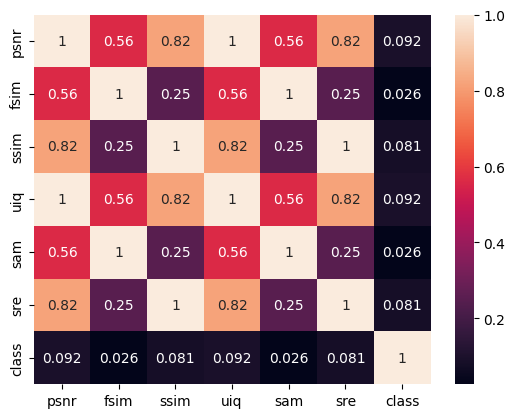

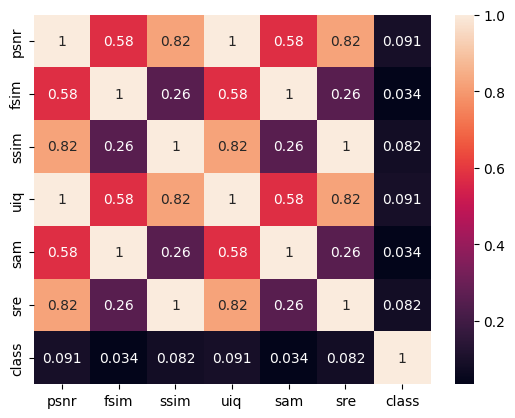

In [6]:
all_train_table_of_score = pd.DataFrame(all_train_table_of_score, columns = ['psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre', 'class'])
all_test_table_of_score = pd.DataFrame(all_test_table_of_score, columns = ['psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre', 'class'])

train_corr_matrix = all_train_table_of_score.corr()
plt.figure()
sns.heatmap(train_corr_matrix, annot=True)

test_corr_matrix = all_test_table_of_score.corr()
plt.figure()
sns.heatmap(test_corr_matrix, annot=True)

### Fit basic discriminator

In [7]:
all_train_table_of_score = pd.DataFrame(all_train_table_of_score, columns = ['psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre', 'class'])
all_test_table_of_score = pd.DataFrame(all_test_table_of_score, columns = ['psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre', 'class'])

mask_train = all_train_table_of_score.apply(np.isinf)
mask_test = all_test_table_of_score.apply(np.isinf)
all_train_table_of_score = all_train_table_of_score[~mask_train.any(axis=1)]
all_test_table_of_score = all_test_table_of_score[~mask_test.any(axis=1)]

In [8]:
all_train_table_of_score = pd.DataFrame(all_train_table_of_score, columns = ['psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre', 'class'])
all_test_table_of_score = pd.DataFrame(all_test_table_of_score, columns = ['psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre', 'class'])

mask_train = all_train_table_of_score.apply(np.isinf)
mask_test = all_test_table_of_score.apply(np.isinf)
all_train_table_of_score = all_train_table_of_score[~mask_train.any(axis=1)]
all_test_table_of_score = all_test_table_of_score[~mask_test.any(axis=1)]

X_train, y_train = all_train_table_of_score[['psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre']].to_numpy(), all_train_table_of_score['class'].to_numpy()
X_test, y_test = all_test_table_of_score[['psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre']].to_numpy(), all_test_table_of_score['class'].to_numpy()


# Normalize X_train, X_test:
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
X_train

array([[ 1.60571879, -0.71416644, -0.6842196 ,  1.60571879, -0.71416644,
        -0.6842196 ],
       [ 1.63495665, -0.71027469, -0.68400027,  1.63495665, -0.71027469,
        -0.68400027],
       [ 1.69164147, -0.70927031, -0.68392679,  1.69164147, -0.70927031,
        -0.68392679],
       ...,
       [ 1.3854068 , -0.71440983, -0.68532871,  1.3854068 , -0.71440983,
        -0.68532871],
       [ 1.42033011, -0.71435284, -0.68519233,  1.42033011, -0.71435284,
        -0.68519233],
       [ 1.25983323, -0.71498053, -0.68566641,  1.25983323, -0.71498053,
        -0.68566641]])

#### SVM

(array([0.]), array([2189]))
(array([0., 1.]), array([1321,  868]))
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75      1321
         1.0       1.00      0.00      0.00       868

    accuracy                           0.60      2189
   macro avg       0.80      0.50      0.38      2189
weighted avg       0.76      0.60      0.45      2189



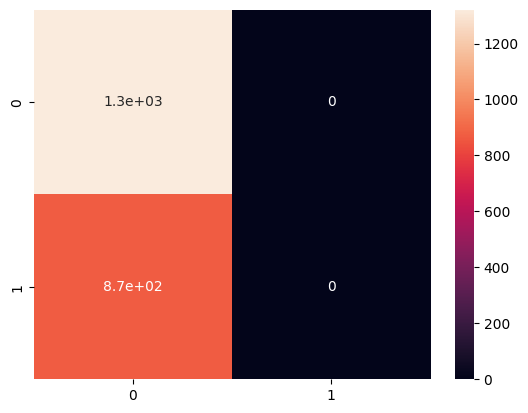

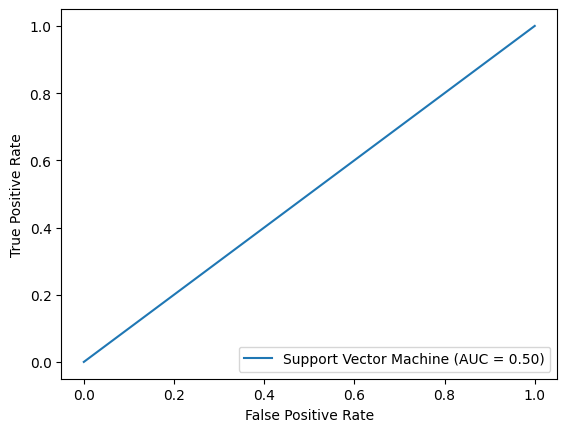

In [9]:
svc = SVC(kernel='rbf', gamma='auto')
svc.fit(X_train, y_train)
svc_y_pred = svc.predict(X_test)

print(np.unique(svc_y_pred, return_counts=True))
print(np.unique(y_test, return_counts=True))
sns.heatmap(confusion_matrix(y_test, svc_y_pred, labels=np.unique(y_test)), annot=True)
print(classification_report(y_test, svc_y_pred, zero_division=1))

svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_y_pred)
roc_auc = auc(svc_fpr, svc_tpr)
svc_roc = RocCurveDisplay(fpr=svc_fpr, tpr=svc_tpr, roc_auc=roc_auc, estimator_name='Support Vector Machine')
svc_roc.plot()

#### RF

(array([0., 1.]), array([1314,  875]))
(array([0., 1.]), array([1321,  868]))
              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70      1321
         1.0       0.54      0.54      0.54       868

    accuracy                           0.64      2189
   macro avg       0.62      0.62      0.62      2189
weighted avg       0.64      0.64      0.64      2189



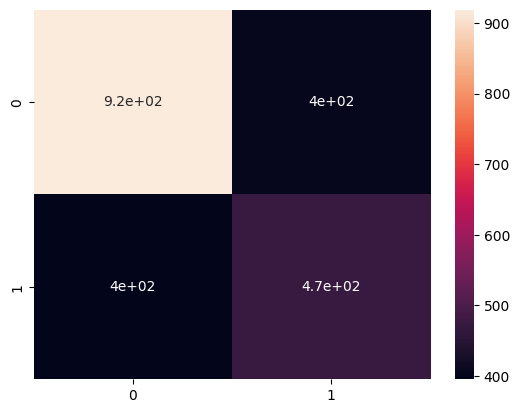

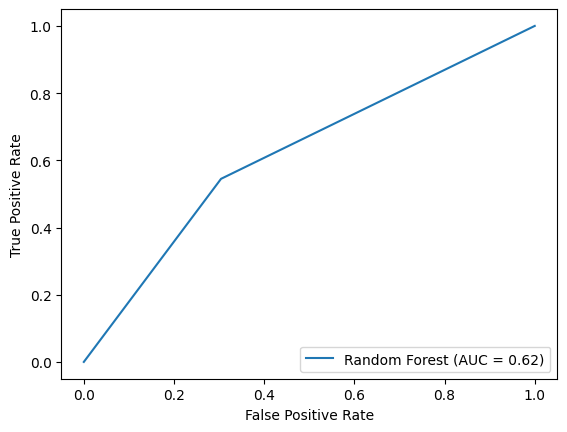

In [10]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

print(np.unique(rf_y_pred, return_counts=True))
print(np.unique(y_test, return_counts=True))
sns.heatmap(confusion_matrix(y_test, rf_y_pred, labels=np.unique(y_test)), annot=True)
print(classification_report(y_test, rf_y_pred, zero_division=1))

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_pred)
roc_auc = auc(rf_fpr, rf_tpr)
rf_roc = RocCurveDisplay(fpr=rf_fpr, tpr=rf_tpr, roc_auc=roc_auc, estimator_name='Random Forest')
rf_roc.plot()

#### Logit Regression

(array([0., 1.]), array([2185,    4]))
(array([0., 1.]), array([1321,  868]))
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75      1321
         1.0       1.00      0.00      0.01       868

    accuracy                           0.61      2189
   macro avg       0.80      0.50      0.38      2189
weighted avg       0.76      0.61      0.46      2189



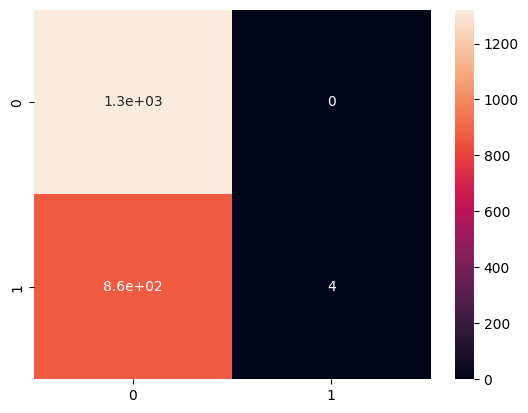

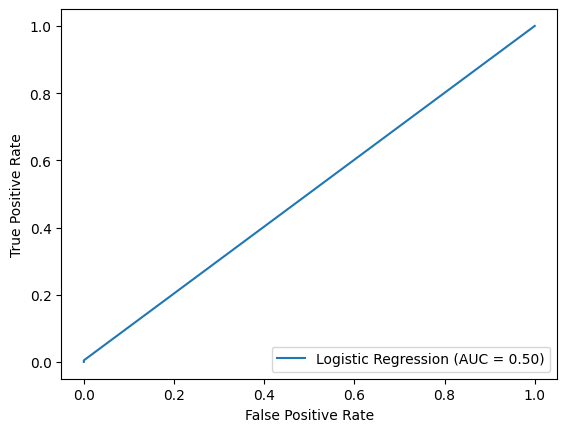

In [11]:
logit = LogisticRegression(random_state=0)
logit.fit(X_train, y_train)
logit_y_pred = logit.predict(X_test)

print(np.unique(logit_y_pred, return_counts=True))
print(np.unique(y_test, return_counts=True))
sns.heatmap(confusion_matrix(y_test, logit_y_pred, labels=np.unique(y_test)), annot=True)
print(classification_report(y_test, logit_y_pred, zero_division=1))

logit_fpr, logit_tpr, _ = roc_curve(y_test, logit_y_pred)
roc_auc = auc(logit_fpr, logit_tpr)
logit_roc = RocCurveDisplay(fpr=logit_fpr, tpr=logit_tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
logit_roc.plot()

#### Simple MLP

In [12]:
learning_rate = 5e-4
batch_size = 256
epochs = 400
n_classes = len(np.unique(y_train))
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [13]:
class BrainTumorDataset(Dataset):
    def __init__(self, data, data_label):
        self.data = data
        self.data_label = data_label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_i = self.data[idx]
        data_label_i = self.data_label[idx]
        
        return data_i, data_label_i

class SimpleMLP(torch.nn.Module):

    def __init__(self, n_class):
        super(SimpleMLP, self).__init__()
        self.mlp = torch.nn.Sequential(torch.nn.Linear(6, 2**3),
                                       torch.nn.BatchNorm1d(2**3),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(0.4),

                                       torch.nn.Linear(2**3, 2**6),
                                       torch.nn.BatchNorm1d(2**6),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(0.4),

                                       torch.nn.Linear(2**6, 2**9),
                                       torch.nn.BatchNorm1d(2**9),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(0.4),

                                       torch.nn.Linear(2**9, 2**6),
                                       torch.nn.BatchNorm1d(2**6),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(0.4),

                                       torch.nn.Linear(2**6, 2**3),
                                       torch.nn.BatchNorm1d(2**3),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(0.4),

                                       torch.nn.Linear(2**3, 1))

    def forward(self, x):
        x = self.mlp(x)
        return x

model = SimpleMLP(2).type(torch.float64)

In [14]:
train_dataset = BrainTumorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BrainTumorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

------------ Epoch: 0 ------------
Epoch: 0 Training loss: 0.641536
Time elapsed: 0.17537236213684082
------------ Epoch: 1 ------------
Epoch: 1 Training loss: 0.628129
Time elapsed: 0.09185123443603516
------------ Epoch: 2 ------------
Epoch: 2 Training loss: 0.614115
Time elapsed: 0.0884852409362793
------------ Epoch: 3 ------------
Epoch: 3 Training loss: 0.605751
Time elapsed: 0.08970880508422852
------------ Epoch: 4 ------------
Epoch: 4 Training loss: 0.600312
Time elapsed: 0.0881812572479248
------------ Epoch: 5 ------------
Epoch: 5 Training loss: 0.591425
Time elapsed: 0.08513045310974121
------------ Epoch: 6 ------------
Epoch: 6 Training loss: 0.586798
Time elapsed: 0.08930587768554688
------------ Epoch: 7 ------------
Epoch: 7 Training loss: 0.583220
Time elapsed: 0.08864426612854004
------------ Epoch: 8 ------------
Epoch: 8 Training loss: 0.578737
Time elapsed: 0.0852653980255127
------------ Epoch: 9 ------------
Epoch: 9 Training loss: 0.573803
Time elapsed: 0.0

Text(0.5, 0, 'Epoch')

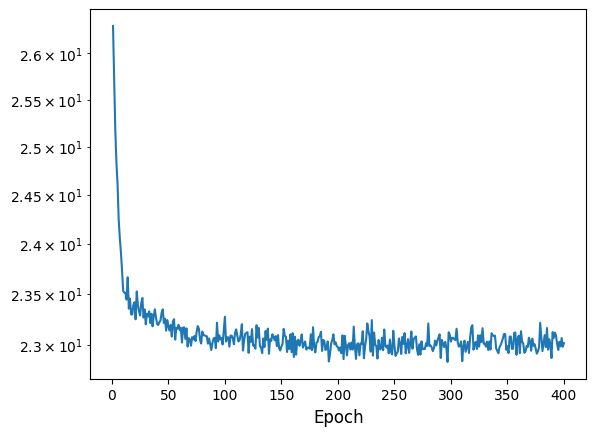

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
#params = [p for p in vgg19.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)
all_loss = []
all_valid_loss = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
for epoch in range(epochs):
    size = len(train_dataloader.dataset)
    print("------------ Epoch:", epoch, "------------")
    training_loss = 0
    valid_loss = 0
    start = time.time()
    for batch, (train_X, train_y) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(train_X.to(device))
        #print(torch.sum(pred[0]))
        loss = loss_fn(pred, train_y.view(-1, 1).to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (batch + 1) * len(train_X)
        #print(loss)
        training_loss += loss
    
    scheduler.step()
    print("Epoch:", epoch,f"Training loss: {training_loss/41:>7f}")
    end = time.time()
    print("Time elapsed:", end - start)
    all_loss.append(training_loss)
    all_valid_loss.append(valid_loss)

fig = plt.figure()
plt.plot(range(1, epochs+1), all_loss)
plt.yscale("log")
plt.xlabel('Epoch', fontsize=12)

(array([0]), array([2189]))
(array([0., 1.]), array([1321,  868]))
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75      1321
         1.0       1.00      0.00      0.00       868

    accuracy                           0.60      2189
   macro avg       0.80      0.50      0.38      2189
weighted avg       0.76      0.60      0.45      2189



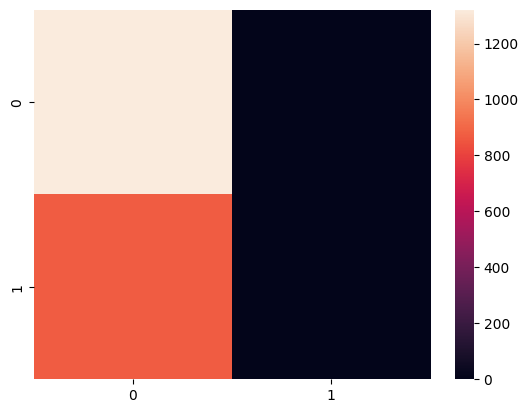

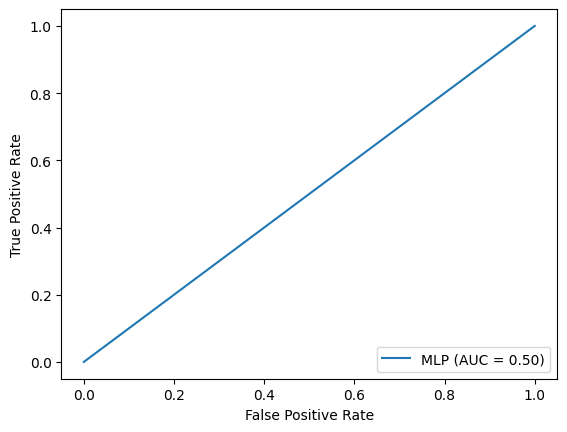

In [16]:
model.to('cpu')
predictions, true_labels = [], []
for batch, (test_X, test_y) in enumerate(test_dataloader):
    # Compute prediction and loss
    pred = torch.argmax(model(test_X), dim=1)
    #print(pred)
    predictions += pred.tolist()
    true_labels += test_y.tolist()

print(np.unique(predictions, return_counts=True))
print(np.unique(true_labels, return_counts=True))

sns.heatmap(confusion_matrix(true_labels, predictions, labels=range(0, n_classes)))
print(classification_report(true_labels, predictions, zero_division=1))

mlp_fpr, mlp_tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(mlp_fpr, mlp_tpr)
mlp_roc = RocCurveDisplay(fpr=mlp_fpr, tpr=mlp_tpr, roc_auc=roc_auc, estimator_name='MLP')
mlp_roc.plot()

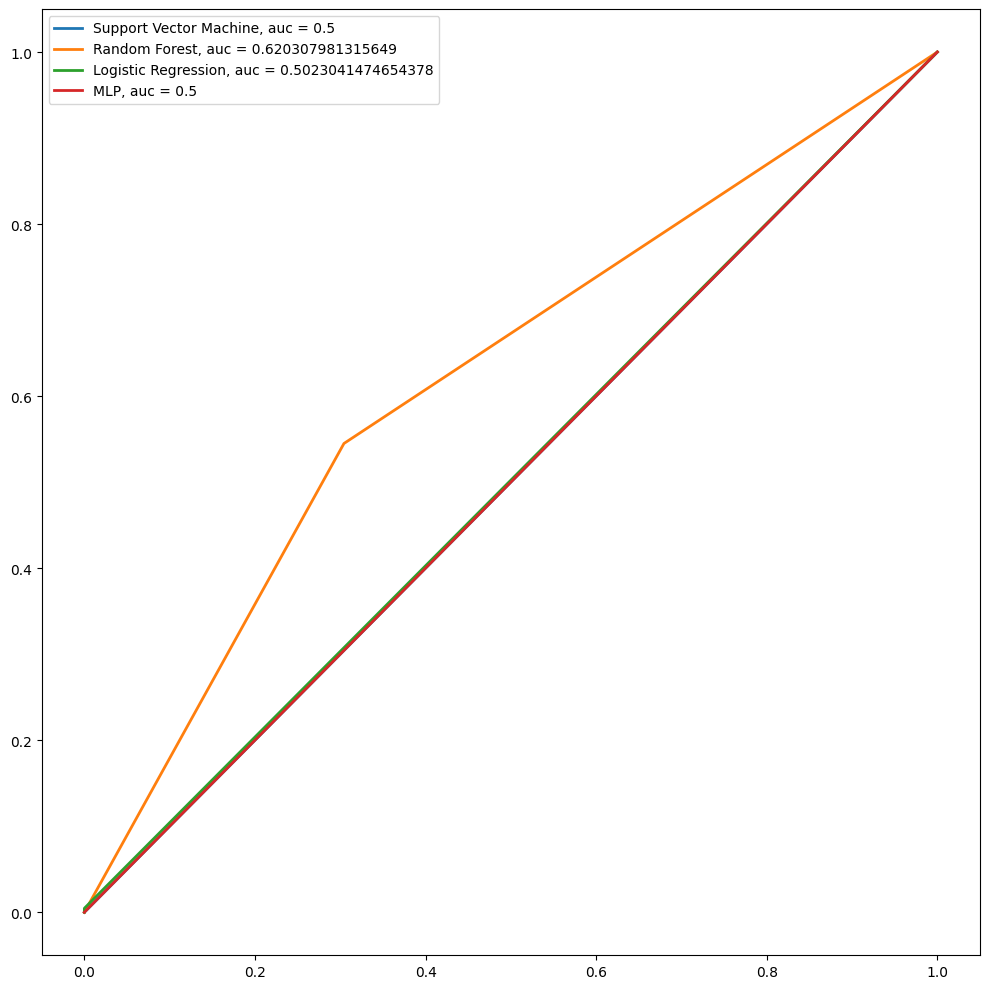

In [17]:
plt.figure(figsize=(10, 10), layout='tight')
plt.plot(svc_fpr, svc_tpr, 
         label='Support Vector Machine, auc = '+str(roc_auc_score(y_test, svc_y_pred)),
         linewidth=2.0)
plt.plot(rf_fpr, rf_tpr, 
         label='Random Forest, auc = '+str(roc_auc_score(y_test, rf_y_pred)),
         linewidth=2.0)
plt.plot(logit_fpr, logit_tpr, 
         label='Logistic Regression, auc = '+str(roc_auc_score(y_test, logit_y_pred)),
         linewidth=2.0)
plt.plot(mlp_fpr, mlp_tpr, 
         label='MLP, auc = '+str(roc_auc_score(true_labels, predictions)),
         linewidth=2.0)
plt.legend()
plt.savefig(root_path + '/Figure/ToS_ROC_Curve.png')
plt.show()

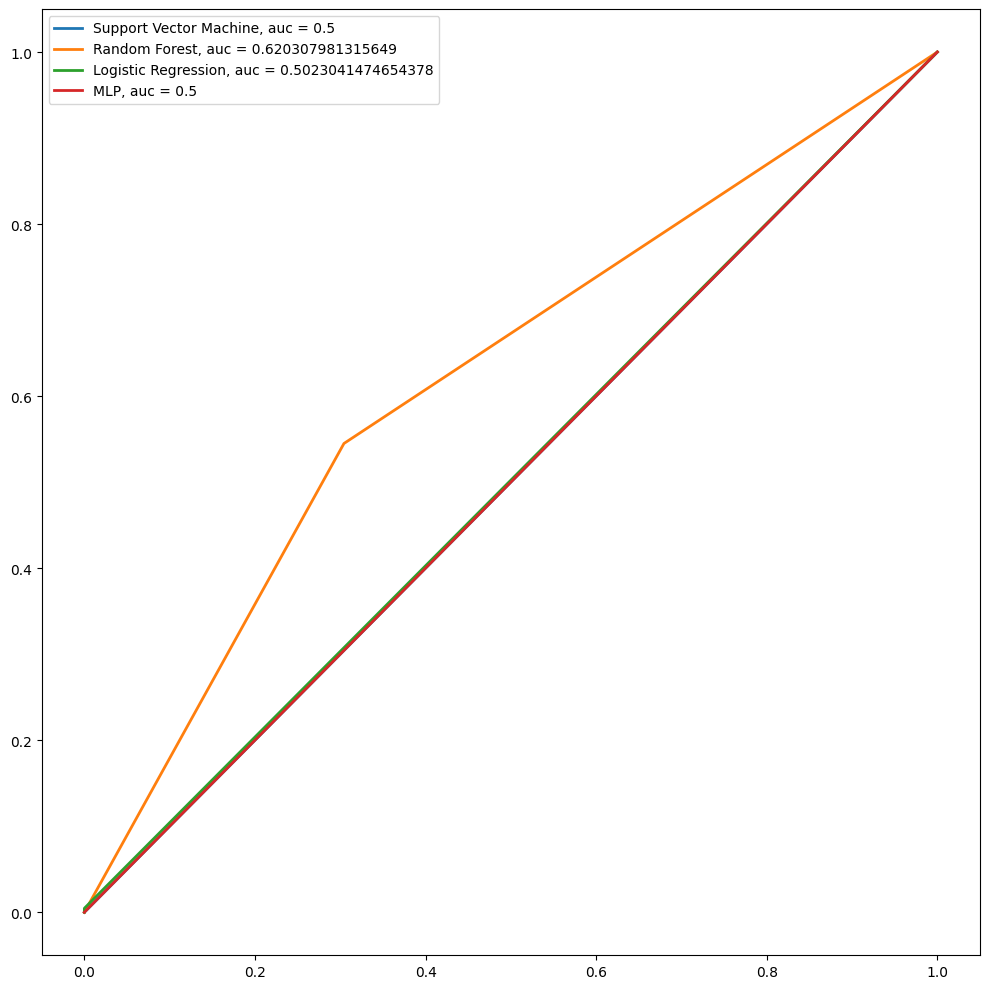

[0.0, 0.5427423981640851, 0.009174311926605503, 0.0]


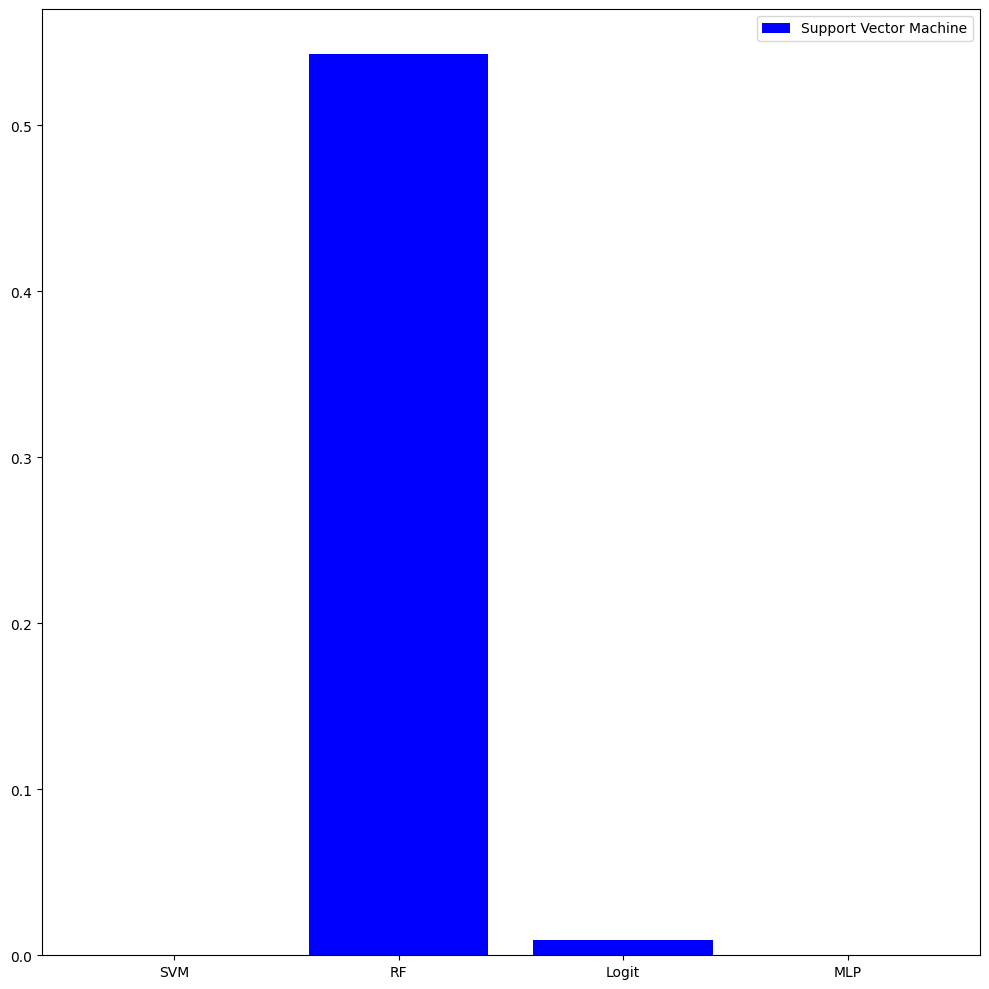

In [18]:
plt.figure(figsize=(10, 10), layout='tight')
plt.plot(svc_fpr, svc_tpr, 
         label='Support Vector Machine, auc = '+str(roc_auc_score(y_test, svc_y_pred)),
         linewidth=2.0)
plt.plot(rf_fpr, rf_tpr, 
         label='Random Forest, auc = '+str(roc_auc_score(y_test, rf_y_pred)),
         linewidth=2.0)
plt.plot(logit_fpr, logit_tpr, 
         label='Logistic Regression, auc = '+str(roc_auc_score(y_test, logit_y_pred)),
         linewidth=2.0)
plt.plot(mlp_fpr, mlp_tpr, 
         label='MLP, auc = '+str(roc_auc_score(true_labels, predictions)),
         linewidth=2.0)
plt.legend()
plt.savefig(root_path + '/Figure/ToS_ROC_Curve.png')
plt.show()

plt.figure(figsize=(10, 10), layout='tight')
x = ['SVM', 'RF', 'Logit', 'MLP']
y = [f1_score(y_test, svc_y_pred, zero_division=1), f1_score(y_test, rf_y_pred, zero_division=1), 
     f1_score(y_test, logit_y_pred, zero_division=1), f1_score(true_labels, predictions, zero_division=1)]
print(y)
plt.bar(x, y, color='blue')
plt.legend(['Support Vector Machine', 'Random Forest', 'Logistic Regression', 'MLP'])
plt.savefig(root_path + '/Figure/ToS_f1_hist.png')
plt.show()